In [2]:
import gymnasium as gym
from tqdm import tqdm
import matplotlib.pyplot as plt

from rl_hockey.td3 import TD3

In [3]:
env_name = 'Pendulum-v1'
# env_name = 'LunarLanderContinuous-v3'

In [4]:
env = gym.make(env_name)
env = gym.wrappers.RescaleAction(env, min_action=-1.0, max_action=1.0)

o_space = env.observation_space
ac_space = env.action_space

/Users/nselcheung/opt/anaconda3/envs/rlhockey/lib/python3.11/site-packages/gymnasium/spaces/box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/nselcheung/opt/anaconda3/envs/rlhockey/lib/python3.11/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [15]:
max_episodes = 500
max_episode_steps = 500
updates_per_step = 1
warmup=10000

In [16]:
new_config = {
    "actor_lr": 3e-4,
    "critic_lr": 3e-4,
    "batch_size": 256,
}

In [17]:
agent = TD3(o_space.shape[0], action_dim=ac_space.shape[0], **new_config)

In [18]:
critic_losses = []
actor_losses = []
rewards = []
gradient_steps = 0
steps = 0

In [19]:
max_episode_steps

500

In [20]:
pbar = tqdm(range(max_episodes), desc=env_name)
for i in pbar:    
    total_reward = 0
    state, _ = env.reset()

    agent.on_episode_start(i)

    for t in range(max_episode_steps):
        done = False
        if steps < warmup:
            action = env.action_space.sample()
        else:
            action = agent.act(state)
            
        (next_state, reward, done, trunc, _) = env.step(action)
        agent.store_transition((state, action, reward, next_state, done))            
        state = next_state

        steps += 1

        if steps >= warmup:
            stats = agent.train(updates_per_step)
            total_reward += reward
            gradient_steps += updates_per_step
            critic_losses.extend(stats['critic_loss'])
            actor_losses.extend(stats['actor_loss'])

        if done or trunc:
            break

    agent.on_episode_end(i)

    rewards.append(total_reward)    
    
    pbar.set_postfix({
        'total_reward': total_reward
    })

agent.save(f'../../../models/td3/{env_name}_{gradient_steps//1000}k.pt')

Pendulum-v1: 100%|██████████| 500/500 [05:15<00:00,  1.58it/s, total_reward=-3.73]   


In [21]:
def moving_average(data, window_size):
    return [sum(data[max(0, i - window_size + 1):i + 1]) / (min(i + 1, window_size)) for i in range(len(data))]

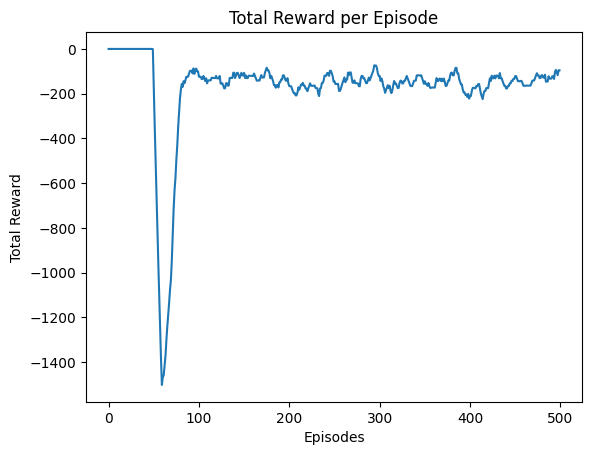

In [22]:
plt.plot(moving_average(rewards, 10))
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()

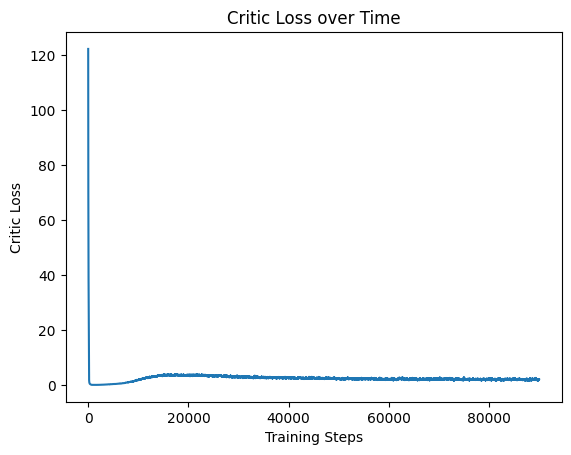

In [23]:
plt.plot(moving_average(critic_losses, 100))
plt.xlabel('Training Steps')
plt.ylabel('Critic Loss')
plt.title('Critic Loss over Time')
plt.show()

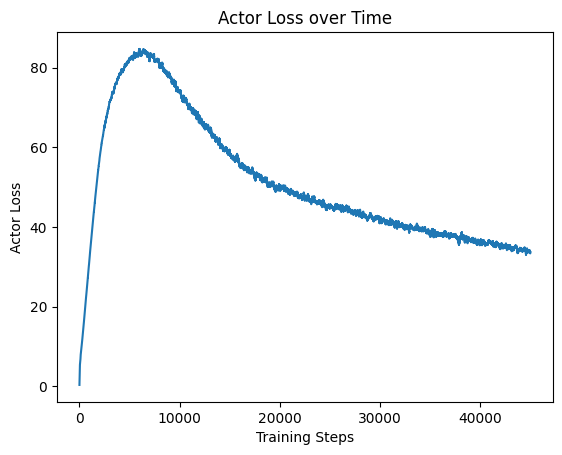

In [24]:
plt.plot(moving_average(actor_losses, 100))
plt.xlabel('Training Steps')
plt.ylabel('Actor Loss')
plt.title('Actor Loss over Time')
plt.show()

In [25]:
env = gym.make(env_name, render_mode='human')
env = gym.wrappers.RescaleAction(env, min_action=-1.0, max_action=1.0)

/Users/nselcheung/opt/anaconda3/envs/rlhockey/lib/python3.11/site-packages/gymnasium/spaces/box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/nselcheung/opt/anaconda3/envs/rlhockey/lib/python3.11/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [26]:
total_reward = 0
state, _ = env.reset()
for t in range(max_episode_steps):
    done = False
    action = agent.act(state)
    (next_state, reward, done, trunc, _) = env.step(action)
    state = next_state

    total_reward += reward

    if done or trunc:
        break

print(f'total_reward: {total_reward}')

/Users/nselcheung/opt/anaconda3/envs/rlhockey/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


total_reward: -0.2538817475856251


In [27]:
env.close()